In [1]:
import PIL
import gc
import torch
import torchvision
import os

import numpy as np
import matplotlib.pyplot as plt  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import Subset
from IPython.core.display import display, HTML
from numpy.random import RandomState
from wide_resnet import WideResNet
from auto_augment import AutoAugment, Cutout
from efficientnet_pytorch import EfficientNet
from cifar_loader import SmallSampleController


# display(HTML("<style>.container { width:40% !important; }</style>"))


In [2]:

def getAcc(preds,targets):
    return np.sum([1 if preds[i] == targets[i] else 0 for i in range(len(preds))])/len(preds)

def train(model, device, train_loader, optimizer, epoch, display=True):
    """
    Summary: Implements the training procedure for a given model
    == params ==
    model: the model to test
    device: cuda or cpu 
    optimizer: the optimizer for our training
    train_loader: dataloader for our train data
    display: output flag
    == output ==
    the mean train loss, the train accuracy
    """
    
    lossTracker = []
    
    targets=[]
    preds=[]
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        lossTracker.append(loss.detach())
        with torch.no_grad():
            pred = torch.argmax(output,1).cpu().numpy()
            preds.extend(pred)
            targets.extend(target.cpu().numpy())
        
    lossTracker = [x.item() for x in lossTracker]
    meanLoss = np.mean(lossTracker)
    accuracy = getAcc(preds,targets)
    if display:
        print('Train Epoch: {} [acc: {:.0f}%]\tLoss: {:.6f}'.format(
          epoch, 100. * accuracy, meanLoss))
        
    return accuracy, meanLoss



def test(model, device, test_loader,verbose=True):
    """
    Summary: Implements the testing procedure for a given model
    == params ==
    model: the model to test
    device: cuda or cpu 
    test_loader: dataloader for our test data
    verbose: output flag
    == output ==
    the mean test loss, the test accuracy
    """
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    meanLoss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if verbose: print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        mean_test_loss, correct, len(test_loader.dataset),
        accuracy))
        
    return accuracy, meanLoss


def checkTest(model,device,valSets,valTracker,latexTracker,epoch,
              model_name,optim_name,lr,totalTestSamples,seed,verbose=True):
    """
    Summary: checks the test accuracy, prints, and saves statistics
    """
    tempAcc = []
    tempLoss = []
    for val_loader in valSets:
        acc,loss = test(model, device, val_loader,verbose = False)
        tempAcc.append(acc)
        tempLoss.append(loss)
        
    meanAcc = np.mean(tempAcc)
    stdAcc = np.std(tempAcc)
    
    meanLoss = np.mean(tempLoss)
    if verbose:
        print('[Trained for {} epochs and tested on {} sets of 2000 images]\
        Avg Acc: {:.2f} +- {:.2f} , Avg Loss: {:.2f}'.format(
            epoch,VALIDATION_SET_NUM,meanAcc,stdAcc,meanLoss))
        
        
    tableRow = getLatexRow(architecture=model_name,epoch=epoch,accuracy=meanAcc,optim=optim_name,
                           lr=lr,totalTestSamples=totalTestSamples,dataAug="Nothing",
                           seed=seed,title=False)
    
    latexTracker.append(tableRow)
        
    valTracker["allLoss"].extend(tempLoss)
    valTracker["allAcc"].extend(tempAcc)
    valTracker["meanLoss"].append(meanLoss)
    valTracker["meanAcc"].append(meanAcc)
    valTracker["stdAcc"].append(stdAcc)





In [3]:
def getLatexRow(architecture,epoch,accuracy,optim,lr,
                totalTestSamples,dataAug,seed,title=False):
    """
    Summary: generates one row of latex for a results table
    """
    categories = ["Model","Epoch","Accuracy","Optimizer","lr","Test Sample Num",
                  "data augmentation","seed"]
    row = [str(architecture),str(epoch),str(round(accuracy,3)),str(optim),
           str(lr),str(totalTestSamples),str(dataAug),str(seed)]
    
    if title:
        c = "&".join(categories)
        r = "&".join(row)
        return "{}\\\\\n{}\\\\".format(c,r)
    else:
        r = "&".join(row)
        return "{}\\\\".format(r)
    
    
def plot(list_,xlab,ylab,title,color,label,save=False):
    """
    Summary: plots the given list of numbers against its idices and 
    allows for high resolution saving
    """
    
    fig = plt.figure()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.plot(
        [(x+1) for x in range(len(list_))],list_,
        color=color,marker=".",
        label=label)
    plt.legend()
    
    if save:
        plt.savefig("{}.pdf".format(title))
        os.system("pdftoppm -png -r 300 {}.pdf {}".format(title,title))
    plt.show()
    
    

In [4]:
def getModel(model_name):
    if "wide" in model_name.lower():
        return WideResNet(28, 10, num_classes=10)
    elif "efficientnet" in model_name.lower():
        tempModel = EfficientNet.from_pretrained(model_name,num_classes = 10)
        return  tempModel 
    
    
def getOptimizer(optimizer_name,parameters):
    if "adam" in  optimizer_name.lower():
        LR = 0.09
        optim = torch.optim.SGD(parameters, 
                                  lr=LR, momentum=0.9,
                                  weight_decay=0.0005)
        return optim, LR
    elif "sdg" in optimizer_name.lower():
        LR = 0.001
        optim = torch.optim.Adam(parameters, 
                              lr=LR, weight_decay=0)
        return optim, LR
        
    

In [5]:
torch.cuda.empty_cache()
gc.collect()

OPTIM = "Adam"
MODEL = "efficientnet-b7"
EPOCH_NUM = 0
TRAIN_SAMPLE_NUM = 100
VAL_SAMPLE_NUM = 2000
BATCH_SIZE = 256
VALIDATION_SET_NUM = 3
AUGMENT = True
VAL_DISPLAY_DIVISOR = 25



normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
if AUGMENT:
    dataAugmentation = [ 
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        AutoAugment(),
        Cutout()
    ]
    augment = "Crop,Flip,AutoAugment,Cutout"
else: 
    dataAugmentation = []
    augment = "Nothing"



transform_train = transforms.Compose(dataAugmentation + [transforms.ToTensor(), normalize]) 
transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same

cifar_train = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
cifar_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)

ss = SmallSampleController(numClasses=10,trainSampleNum=TRAIN_SAMPLE_NUM, # abstract the data-loading procedure
                           valSampleNum=VAL_SAMPLE_NUM, batchSize=BATCH_SIZE, 
                           multiplier=VALIDATION_SET_NUM, trainDataset=cifar_train, 
                           valDataset=cifar_val)
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data, valSets, seed = ss.generateNewSet(device,valMultiplier = VALIDATION_SET_NUM) #Sample from datasets


model = getModel(MODEL).cuda()
optimizer,LR = getOptimizer(OPTIM,model._fc.parameters())


print(model.parameters)
    

print(' => Total trainable parameters: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))        

trainTracker = {"meanLoss":[],"accuracy":[]}
valTracker = {"allLoss":[],"allAcc":[],"meanLoss":[],"meanAcc":[],"stdAcc":[]}
latexTracker = []

print("Begin Train for {} epochs".format(EPOCH_NUM))
for epoch in range(EPOCH_NUM):
    acc, loss = train(model, device, train_data[0], optimizer, epoch+1, display=True)
    trainTracker["meanLoss"].append(loss)
    trainTracker["accuracy"].append(acc)
    
    if (epoch+1) % VAL_DISPLAY_DIVISOR == 0:
        checkTest(model,device,valSets,valTracker,latexTracker,epoch+1,
              model_name=MODEL,optim_name=OPTIM,lr=LR,totalTestSamples=VAL_SAMPLE_NUM*VALIDATION_SET_NUM,
                  seed=seed,verbose=True)
        
          
        
        

Files already downloaded and verified
Files already downloaded and verified
Loaded pretrained weights for efficientnet-b7
<bound method Module.parameters of EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 

In [6]:
for x in latexTracker:
    print(x)

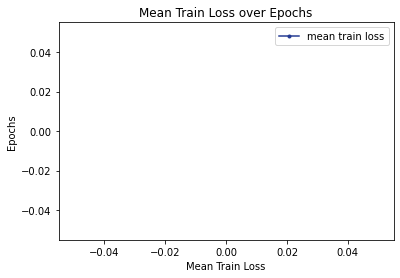

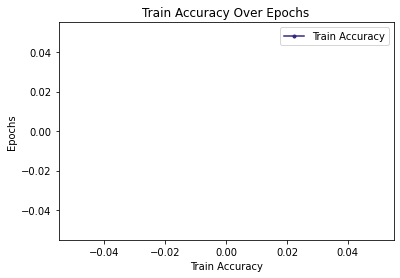

In [7]:
plot(list_=trainTracker["meanLoss"],xlab="Mean Train Loss",
    ylab="Epochs",title="Mean Train Loss over Epochs",
    color="#243A92",label="mean train loss",save=True)

plot(list_=trainTracker["accuracy"],xlab="Train Accuracy",
    ylab="Epochs",title="Train Accuracy Over Epochs",
    color="#34267E",label="Train Accuracy",save=True)

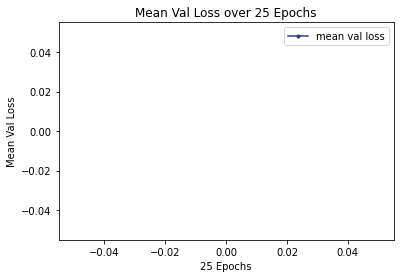

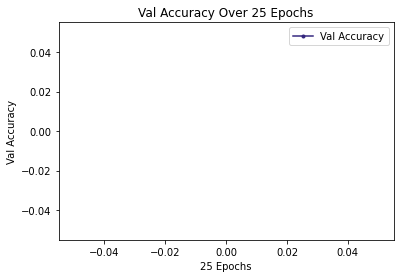

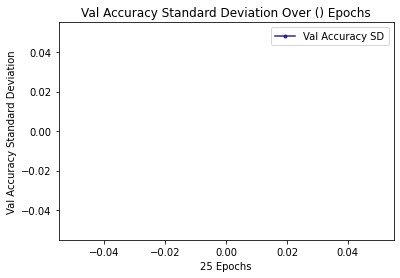

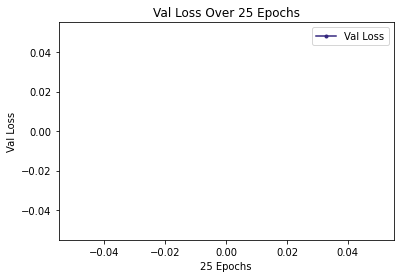

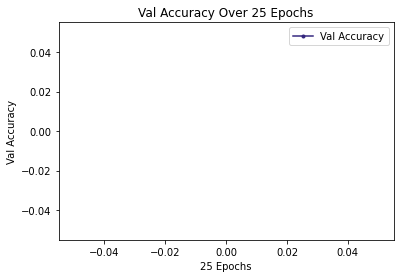

In [8]:
plot(list_=valTracker["meanLoss"],xlab="{} Epochs".format(VAL_DISPLAY_DIVISOR),
    ylab="Mean Val Loss",title="Mean Val Loss over {} Epochs".format(VAL_DISPLAY_DIVISOR),
    color="#243A92",label="mean val loss",save=True)

plot(list_=valTracker["meanAcc"],xlab="{} Epochs".format(VAL_DISPLAY_DIVISOR),
    ylab="Val Accuracy",title="Val Accuracy Over {} Epochs".format(VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Accuracy",save=True)

plot(list_=valTracker["stdAcc"],xlab="{} Epochs".format(VAL_DISPLAY_DIVISOR),
    ylab="Val Accuracy Standard Deviation",title="Val Accuracy Standard Deviation Over () Epochs".format(VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Accuracy SD",save=True)

plot(list_=valTracker["allLoss"],xlab="{} Epochs".format(VAL_DISPLAY_DIVISOR),
    ylab="Val Loss",title="Val Loss Over {} Epochs".format(VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Loss",save=True)

plot(list_=valTracker["allAcc"],xlab="{} Epochs".format(VAL_DISPLAY_DIVISOR),
    ylab="Val Accuracy",title="Val Accuracy Over {} Epochs".format(VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Accuracy",save=True)